Dataset [link](https://can01.safelinks.protection.outlook.com/?url=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1-6sd6E3cL8uWdNeO4xiXxLbTSYXSTiVr%3Fusp%3Dsharing&data=04%7C01%7Carash.gholami%40queensu.ca%7C92b180b5b67d475fb70e08d87b7f4305%7Cd61ecb3b38b142d582c4efb2838b925c%7C1%7C0%7C637395133804367020%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C1000&sdata=1ieR3E8llMblC0QMBtx1%2FpHS71RQuCxzdNQLmH0HJVU%3D&reserved=0)

Explanation: There are **49** users' data here. Naming is in the format of Username_ExperimentNumber. Please also note that it is unprocessed raw data, which includes a lot of noise etc. 

Experiment-1: **20** participants are involved in this task and the participants were asked to type **a story** from **a set** of short and simple stories from the American Literature https://americanliterature.com/100-great-short-stories for **four minutes**. The story was chosen randomly by the participants.

Experiment-2: 20 participants are involved in this task and for this data set, all the participants were asked to type the **same text** https://en.wikipedia.org/wiki/The_Adventures_of_Tom_Sawyer for **four minutes**. For each participant, almost the same amount of data is collected as Experiment-1. This dataset is important to be able to measure the quality of the features. The collection of this dataset is quite realistic since in a real case the users could be also asked to type a given text during their CA sessions. 

Experiment-3: The participants are asked to type **10 different pangram sentences**. Pangrams sentences contain** all 26 letters** of the alphabet. This data set is used to test how the **letter distribution** of text affects the result.

Experiment-4: **34** participants are involved in this task and the participants were instructed to imitate someone else's typing pattern by watching the prerecorded video of the other person. For these experiments, one of the participants was recorded on video while typing a short and simple sentence for **15 seconds** from a perspective that the hand motions, smartwatch, keyboard, and the screen could be seen. Although it was not required, the perspective allowed to infer what the victim was typing by watching. This dataset was primarily used to analyze the **attacking scenarios**. It is left to the participant to type the exact same text or imitate the hand movement of the victim.

-----------------------

I realized that you have mostly 4s and 10s as values on column A, but I also found 2s. What does column A represent? 
A represents the sensor type:
 
**10 for the accelerometer
4 for the gyroscope**
2 for the magnetic field sensor

You can find more info about sensors and constant values that are used to define the sensor type in these links:
- https://developer.android.com/guide/topics/sensors/sensors_overview
- https://developer.android.com/reference/android/hardware/Sensor#TYPE_LINEAR_ACCELERATION

Normally, I only collected and used accelerometer and gyroscope sensor data. Magnetometer data should not be in the dataset. If there is, that means it is an **outlier**.
 
Is column B the time stamp, is it recorded at 100HZ?

In an android app, you can set the sampling rate "SENSOR_DELAY_NORMAL, SENSOR_DELAY_UI, SENSOR_DELAY_GAME, or SENSOR_DELAY_FASTEST " 

As far as I remember I used **"SENSOR_DELAY_FASTEST" for all sensors**, but in practice, I had a lot of issues regarding this. They **don't give a constant sampling rate**. Every time I used they were giving different sampling rates. They were giving different sampling rates for two sessions of the same user, for different users, or for different sensors. Therefore, I would recommend using the one in the practice, which you can calculate using the timestamp and the sample count. 

On the paper you said you have recorded both accelerometer and gyro data; but you seem to only have one of them at a time on columns C, D, and F. I am guessing 10 on column A represents accelerometer and 4 gyro, but I could be wrong. 
Also, some rows have more columns, and start with 11 on column A. What do those represent?
Please see the explanation above. 
 

In short, I would really appreciate it if you could let me know information I need to know for working with the data.

Also, as these sensors were giving me a lot of headaches because they are really not stable, I needed to perform a lot of preprocessing. I **cleaned the outliers** before further processing. I also applied some other filtering techniques such as **moving average** to obtain more smooth data. Moreover, I needed to **clean the part the users are not performing typing operation from the beginning and end**, which you can see if you plot the values, i.e., the **user stops meaning no value and then big deviations, where the user takes off the smartwatch**.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

CORES = -1
SEED = 567

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install --upgrade pip
# !pip install python-docx
# !pip install antropy

from sklearn.neighbors import NearestNeighbors
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
import math as math
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
import statsmodels.stats.api as sms
from tqdm.auto import tqdm
from dataclasses import asdict
from sklearn import svm
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, accuracy_score, make_scorer, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.model_selection import KFold

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import iqr
from scipy.stats import median_absolute_deviation
from scipy.stats import mode
from scipy.signal import find_peaks
from scipy.signal import peak_widths
# from scipy.special import entr
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
get_new_scaler_dict = {"StandardScaler": StandardScaler, "MinMaxScaler": MinMaxScaler, "Normalizer": Normalizer, 
                       "MaxAbsScaler": MaxAbsScaler, "RobustScaler": RobustScaler, "PowerTransformer": PowerTransformer}
from sklearn.preprocessing import normalize
from sklearn.metrics import auc
# import antropy as ant
import time
# import docx

# Global utitlity functions are in separate notebook
# import utility_functions as uf
%run ./utility-functions.ipynb

np.random.seed(SEED)
print(f"Numpy Seed was set to: {SEED}")

print("Setup Complete")

utility_functions imports setup complete
Python 3.9.10
utility functions imported
Numpy Seed was set to: 567
Setup Complete


In [3]:
import sklearn
sklearn.__dir__()
sklearn.__version__

'1.0.2'

In [4]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Parameter set. Used as identifier for charts etc.
    frequency: int
    max_subjects: int
    max_test_subjects: int
        
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
    
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    window_size: int  # After resampling
    ocsvm_step_width: int  # After resampling
    scaler: str  # StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # fit transform scale on all data (True) or fit on training only (False)
    ocsvm_kernel: str # ocsvm kernel
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model
    feature_cols: list  # Columns used as features
    exclude_subjects: list  # Don't load data from those users
        
    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        

# INSTANCES
# ===========================================================

# NAIVE_APPROACH
# -----------------------------------------------------------
NAIVE_MINMAX_OCSVM = ExperimentParameters(
    name="NAIVE-MINMAX_OCSVM",
    frequency=100,
    max_subjects=29,
    max_test_subjects=10,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    seconds_per_subject_train=210,
    seconds_per_subject_test=210,    
    window_size=250,
    ocsvm_step_width=250,
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    ocsvm_kernel="rbf",
    ocsvm_nu=None,
    ocsvm_gamma=None,
    feature_cols=[
        "EMA_x_a",
        "EMA_y_a",
        "EMA_z_a",
        "EMA_x_g",
        "EMA_y_g",
        "EMA_z_g",
    ],
    exclude_subjects=[],
)

# VALID_APPROACH
# -----------------------------------------------------------
VALID_MINMAX_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-MINMAX-OCSVM",
    scaler_global=False,
    ocsvm_nu=0.165,
    ocsvm_gamma=0.039,
)

# NAIVE_ROBUST_APPROACH
# -----------------------------------------------------------
NAIVE_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="NAIVE-ROBUST-OCSVM",
    scaler="robust",
    scaler_global=True,
    ocsvm_nu=0.153,
    ocsvm_gamma=0.091,  # below median, selected by chart
)

# ROBUST_APPROACH (VALID)
# -----------------------------------------------------------
VALID_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    ocsvm_nu=0.037,
    ocsvm_gamma= 0.001,
)
# NORMALIZER_APPROACH (VALID)
# -----------------------------------------------------------
VALID_NORMALIZER_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-NORMALIZER-OCSVM",
    scaler="Normalizer",
    scaler_global=False,
    ocsvm_nu=0.074,
    ocsvm_gamma= 0.029,
)

In [5]:
P = VALID_ROBUST_OCSVM
# P = VALID_NORMALIZER_OCSVM

In [6]:
utils_ppp(P)

,Value
name,VALID-ROBUST-OCSVM
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [7]:
utils_eer_scorer

make_scorer(utils_eer, greater_is_better=False)

# Split Dataset for Valid/Test  
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

They did a 30 60 split.

# Reshaping Raw Features.
We have our own function of windows for this. Do this for both training and testing.

# Extracting time and frequency based features.
Again, we have a function for this. Do this for both training and testing.

# Hyperparameter Optimization 

I do not find any reaqsonable explaination how to use a cross-validation as we are talking about anomaly detection.

I am using the experiment 1 data as train, and experiment 2 data as validation.

# Using SVM in a real-world Scenario with multiple genuine users and intruders
Source: https://datascience.stackexchange.com/questions/23623/what-is-the-best-way-to-classify-data-not-belonging-to-set-of-classes

Stage 1: 
    Use one-class SVM to assign those images that do not belong to the set of predefined classes as the 9-th class.

Stage 2:
    For those images that passes through your filter, let the multi-class SVM assign them to one of the 8 classes.

Loading data:

In [8]:
#include 47 later
# user_ids = [9]
df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
dfList_exp1, dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

Loading exp1 data:


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


1) accel_count: 28388, gyro_count: 31997
2) accel_count: 26015, gyro_count: 28954


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


3) accel_count: 28227, gyro_count: 31814
4) accel_count: 24862, gyro_count: 26103


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


5) accel_count: 24270, gyro_count: 24347
6) accel_count: 25012, gyro_count: 25060


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


7) accel_count: 25301, gyro_count: 25382
8) accel_count: 21985, gyro_count: 21658


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


19) accel_count: 24122, gyro_count: 25050
21) accel_count: 24367, gyro_count: 23830


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


22) accel_count: 29284, gyro_count: 28863
26) accel_count: 23148, gyro_count: 24291


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


27) accel_count: 24299, gyro_count: 23589
28) accel_count: 23807, gyro_count: 24523


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


29) accel_count: 24030, gyro_count: 23475
35) accel_count: 24388, gyro_count: 23673


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


36) accel_count: 24244, gyro_count: 24208
37) accel_count: 32022, gyro_count: 31843


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


38) accel_count: 22138, gyro_count: 22327
39) accel_count: 23573, gyro_count: 23459


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


40) accel_count: 23057, gyro_count: 24296
41) accel_count: 24102, gyro_count: 23681


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


42) accel_count: 24074, gyro_count: 24328
43) accel_count: 22631, gyro_count: 23835


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


44) accel_count: 24474, gyro_count: 23749
45) accel_count: 23974, gyro_count: 23229


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


46) accel_count: 23614, gyro_count: 23827
48) accel_count: 22828, gyro_count: 23904


/tmp/ipykernel_847/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


49) accel_count: 24183, gyro_count: 24633
Loading exp2 data:
1) accel_count: 24049, gyro_count: 26943


/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


2) accel_count: 24472, gyro_count: 27667
3) accel_count: 24611, gyro_count: 27000


/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


4) accel_count: 24972, gyro_count: 26798
5) accel_count: 23573, gyro_count: 23372


/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


6) accel_count: 23800, gyro_count: 23890
7) accel_count: 23347, gyro_count: 24145


/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


8) accel_count: 22964, gyro_count: 22660
19) accel_count: 26160, gyro_count: 25846


/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


21) accel_count: 23642, gyro_count: 24444
22) accel_count: 23863, gyro_count: 24589


/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


26) accel_count: 23179, gyro_count: 23925
27) accel_count: 25121, gyro_count: 25829


/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


28) accel_count: 23133, gyro_count: 24039
29) accel_count: 23180, gyro_count: 24314


/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


35) accel_count: 23299, gyro_count: 23854
36) accel_count: 25500, gyro_count: 25059


/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


37) accel_count: 25994, gyro_count: 25232
38) accel_count: 21168, gyro_count: 21182


/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


39) accel_count: 24214, gyro_count: 23585
40) accel_count: 23944, gyro_count: 23170


/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


41) accel_count: 23195, gyro_count: 24111
42) accel_count: 26505, gyro_count: 25697


/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


43) accel_count: 22692, gyro_count: 23982
44) accel_count: 23002, gyro_count: 23829


/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


45) accel_count: 23978, gyro_count: 23350
46) accel_count: 21128, gyro_count: 21848


/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_847/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


48) accel_count: 28000, gyro_count: 27205
49) accel_count: 23071, gyro_count: 24129


In [9]:
# i=0
# dfList_exp1[i][['EMA_x_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_y_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_z_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_x_g']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_y_g']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_z_g']].plot(figsize=(30, 6))

# dfList_exp2[i][['EMA_x_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_y_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_z_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_x_g']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_y_g']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_z_g']].plot(figsize=(30, 6))
# exp1 idx 10 has corrupted data frist 50 sec
# exp2 idx 12 has some artifacts first 12.5 sec
# exp1 idx 17 has some artifacts first 75 sec
# exp2 idx 23 has some artifacts last 6.5 sec

In [10]:
randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
split_idx = 2 * (len(randomized_data_idx)//3) + 1
train_set = randomized_data_idx[: split_idx]
test_set = randomized_data_idx[split_idx: ]
train_set = randomized_data_idx
print(f"train_set: {train_set}\ntest_set: {test_set}")
train_set = test_set
# test_set = train_set
print(f"train_set: {train_set}\ntest_set: {test_set}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
train_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


In [11]:
def get_raw_windows(window_size, step_width):
    P.window_size = window_size
    P.ocsvm_step_width = step_width
    # preparing train data
    # train_set = r
    dfList_exp1_train, dfList_exp2_train = [dfList_exp1[i] for i in train_set], [dfList_exp2[i] for i in train_set]
    print(f"len(dfList_exp1_train): {len(dfList_exp1_train)}")
    print(f"len(dfList_exp2_train): {len(dfList_exp2_train)}")
    XExpTrainDict = MakeRawXExpDic(dfList_exp1_train, dfList_exp2_train, window_size = P.window_size, step=P.ocsvm_step_width, numSamplePoints=P.num_sample_points_per_exp, 
                                          scale_exp1=False, scale_exp2=True, scaler=P.scaler)

    fitted_scaler_ocsvm_exp2_train_dic = XExpTrainDict["fitted_scaler_exp2_dic"]
    X_exp1_train_dic, X_exp2_train_dic = XExpTrainDict["Raw_X_exp1_dic"], XExpTrainDict["Raw_X_exp2_dic"]

    # preparing test data
    dfList_exp1_test, dfList_exp2_test = [dfList_exp1[i] for i in test_set], [dfList_exp2[i] for i in test_set]
    print(f"len(dfList_exp1_test): {len(dfList_exp1_test)}")
    print(f"len(dfList_exp2_test): {len(dfList_exp2_test)}")
    XExpTestDict = MakeRawXExpDic(dfList_exp1_test, dfList_exp2_test, window_size = P.window_size, step=P.ocsvm_step_width, numSamplePoints=P.num_sample_points_per_exp, 
                                          scale_exp1=False, scale_exp2=True, scaler=P.scaler)

    fitted_scaler_ocsvm_exp2_test_dic = XExpTestDict["fitted_scaler_exp2_dic"]
    X_exp1_test_dic, X_exp2_test_dic = XExpTestDict["Raw_X_exp1_dic"], XExpTestDict["Raw_X_exp2_dic"]
    
    #----
    return X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic

In [12]:
print(f"train_set: {train_set}")
# print(f"X_exp1_train_dic: {X_exp1_train_dic.keys()}")
# print(f"X_exp2_train_dic: {X_exp2_train_dic.keys()}")

train_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


In [13]:
print(f"test_set: {test_set}")
# print(f"X_exp1_test_dic: {X_exp1_test_dic.keys()}")
# print(f"X_exp2_test_dic: {X_exp2_test_dic.keys()}")

test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


In [14]:
def extract_features(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic):
    X_exp_train_dic = MakeWACAXExpDicOwner(X_exp2_train_dic, scaler_clip=True, scaler_type="MinMaxScaler")
    X_exp_train_dic = MakeWACAXExpDicUnknown(X_exp1_train_dic, X_exp_train_dic, fitted_raw_scaler_dict=fitted_scaler_ocsvm_exp2_train_dic)
    X_exp_test_dic = MakeWACAXExpDicOwner(X_exp2_test_dic, scaler_clip=True, scaler_type="MinMaxScaler")
    X_exp_test_dic = MakeWACAXExpDicUnknown(X_exp1_test_dic, X_exp_test_dic, fitted_raw_scaler_dict=fitted_scaler_ocsvm_exp2_test_dic)
    
    return X_exp_train_dic, X_exp_test_dic

In [15]:
# OCSVM_test_train_WACA_features_dic[0].shape

In [19]:
# def normalize_extracted_features(OCSVM_train_train_WACA_features_dic, OCSVM_train_valid_WACA_features_dic, OCSVM_test_train_WACA_features_dic, OCSVM_test_test_WACA_features_dic, scaler_clip=True):
#     train_train_WACA_features_result = scale_feature_windows(OCSVM_train_train_WACA_features_dic, fitted_scaler_dic=None, scaler_type="MinMaxScaler", scaler_clip=scaler_clip)
#     OCSVM_train_train_WACA_features_dic, fitted_scaler_dic = train_train_WACA_features_result["X_exp_dic"], train_train_WACA_features_result["fitted_scaler_dic"]

#     train_valid_WACA_features_result = scale_feature_windows(OCSVM_train_valid_WACA_features_dic, fitted_scaler_dic=fitted_scaler_dic)
#     OCSVM_train_valid_WACA_features_dic = train_valid_WACA_features_result["X_exp_dic"]

#     return OCSVM_train_train_WACA_features_dic, fitted_scaler_dic, OCSVM_train_valid_WACA_features_dic

In [19]:
def plot_EER_distro(EER_distro_df, discription, save_file_name=None):
    y_col = "EER"
    figsize=(30, 6)
    fontsize=11
    n_subject = len(EER_distro_df.columns)
    mean_col = EER_distro_df[y_col].mean()

    fig = plt.figure(figsize=figsize, dpi=180)
    ax = sns.boxplot(x="gen_user_id", y=y_col, data=EER_distro_df)#, **utils_boxplot_style)
    ax.set_ylim((0, 1))
    sns.swarmplot(x="gen_user_id", y=y_col, data=EER_distro_df, color=".25")

    plt.plot(
        [-0.6, figsize[0] + 0.6],
        [mean_col, mean_col],
        linestyle="dashed",
        linewidth=1,
        color=MAGENTA,
        alpha=0.7,
    )
    plt.text(n_subject + 0.6, mean_col, f"mean", fontsize=fontsize, color=MAGENTA)
    plt.text(
        n_subject + 0.6, mean_col - 0.04, f"{mean_col:.3f}", fontsize=fontsize, color=MAGENTA
    )
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.title(discription)
    
    plt.savefig(f'{save_file_name}.png', bbox_inches='tight')
    print(f"Overall mean: {mean_col:.4f}")

In [156]:
def make_EER_distro_df(X_exp_dic):
    columns = ['owner', "adv_user_id", "EER"]
    y_pred_tres_EER_dic = {} 
    EER_distro_df = pd.DataFrame(columns = columns)
    for owner in X_exp_dic.keys():
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X_exp_dic[owner]["profile_windows"])
        curr_EER_distro_lst = [] 
        df = pd.DataFrame()
        y_pred_tres_EER_dic[owner] = {}
        
        distFRR, FRR_indices = nbrs.kneighbors(X_exp_dic[owner]["unknown_users_dict"][owner])
        distFRR = distFRR.mean(axis=1).reshape(distFRR.shape[0], 1)
        for adv_user_id in X_exp_dic.keys():
    #         if adv_user_id != 16 and adv_user_id != gen_user_id and gen_user_id != 16:
            if adv_user_id != owner and owner != 16:
                distFAR, FAR_indices = nbrs.kneighbors(X_exp_dic[owner]["unknown_users_dict"][adv_user_id])
                distFAR = distFAR.mean(axis=1).reshape(distFAR.shape[0], 1)
                df[adv_user_id] = distFAR.mean(axis=1)


                all_dist = np.concatenate([distFAR, distFRR])
    #             print(all_dist.shape)
                scaler = MinMaxScaler().fit(all_dist)
                scaled_distFRR, scaled_distFAR = scaler.transform(distFRR), scaler.transform(distFAR)



                y = [1]*distFRR.shape[0] + [-1]*distFAR.shape[0]
                y_pred = 1-np.concatenate([scaled_distFRR, scaled_distFAR]).ravel() 
                # sns.lineplot(np.arange(y_pred.shape[0]), y_pred)
                temp_eer, tres = utils_eer(y, y_pred, return_threshold=True)
                curr_EER_distro_lst.append(temp_eer)
                # print("-"*40)
                # print(y_pred)
                y_pred_tres_EER_dic[owner][adv_user_id] = {"y_pred": y_pred, "tres": tres, "EER": temp_eer}
                # print(f"FRR: {y_pred[:y_pred.shape[0]//2]>=tres}")
                # print(f"FAR: {y_pred[y_pred.shape[0]//2:]<tres}")
                print(f"EER: {temp_eer:.9f}, owner_id: {owner}, adv_user_id: {adv_user_id}, Threshold: {tres:.9f}")
                
                new_row = pd.DataFrame([[owner, adv_user_id, temp_eer]], columns=columns)
                EER_distro_df = pd.concat([EER_distro_df, new_row])
                # return EER_distro_df
    #     if gen_user_id != 16:
    #         print(len(curr_EER_distro_lst))
    # #         EER_distro_df["Owner"] = gen_user_id
    #         EER_distro_df[gen_user_id] = np.array(curr_EER_distro_lst)

#         if owner != 16:
#             df.plot(figsize=(30, 6), title=f"owner_id: {owner}") # uncomment when more storage
    
    return EER_distro_df, y_pred_tres_EER_dic

In [141]:
# import sys, os

# temp_stdout = sys.stdout

# # Disable
# def blockPrint():
#     global temp_stdout
#     temp_stdout = sys.__stdout__
#     sys.stdout = open(os.devnull, 'w')

# # Restore
# def enablePrint():
#     global temp_stdout
#     sys.stdout = sys.__stdout__

# import warnings
warnings.filterwarnings("ignore")
# enablePrint()

In [142]:
type(fitted_scaler_ocsvm_exp2_train_dic[0])

NameError: name 'fitted_scaler_ocsvm_exp2_train_dic' is not defined

In [143]:
# window_size, step_width = 500, 500
# X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic = \
#     get_raw_windows(window_size, step_width)
# X_exp_train_dic, X_exp_test_dic = \
#     extract_features(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic)

# EER_distro_df = make_EER_distro_df(OCSVM_train_train_WACA_features_dic, OCSVM_train_valid_WACA_features_dic)
# EER_distro_df

In [144]:
# plot_EER_distro(Mean_EER_df, 500)

In [145]:
'''
EER_distro_df = make_EER_distro_df(X_exp_train_dic)
EER_distro_df

columns = ['window_size', "step_width", "scaler_clip", "Mean_EER"]
Mean_EER_df = pd.DataFrame(columns = columns)
y_col = "EER"
mean_col = EER_distro_df[y_col].mean()
Mean_EER = mean_col

new_row = pd.DataFrame([[window_size, step_width, True, Mean_EER]], columns=columns)
Mean_EER_df = pd.concat([Mean_EER_df, new_row])
'''

'\nEER_distro_df = make_EER_distro_df(X_exp_train_dic)\nEER_distro_df\n\ncolumns = [\'window_size\', "step_width", "scaler_clip", "Mean_EER"]\nMean_EER_df = pd.DataFrame(columns = columns)\ny_col = "EER"\nmean_col = EER_distro_df[y_col].mean()\nMean_EER = mean_col\n\nnew_row = pd.DataFrame([[window_size, step_width, True, Mean_EER]], columns=columns)\nMean_EER_df = pd.concat([Mean_EER_df, new_row])\n'

In [146]:
#X_exp_train_dic[0]["profile_windows"].max(axis=0)

In [147]:
window_size = 1000
int(window_size*(1-.75))


250

In [157]:
def calculate_EER_different_winddow_sizes(overlap=.25):
    EER_distro_df_dict = {}
    window_size_lst = [750]# 125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000
    scaler_clip = True
    columns = ['window_size', "step_width", "scaler_clip", "Mean_EER"]
    Mean_EER_df = pd.DataFrame(columns = columns)
    for window_size in tqdm(window_size_lst):
        print(window_size)
        # blockPrint()
        step_width = int(window_size * (1-overlap))
        X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic = \
            get_raw_windows(window_size, step_width)
        X_exp_train_dic, X_exp_test_dic = \
            extract_features(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic)

        EER_distro_df, y_pred_tres_EER_dic = make_EER_distro_df(X_exp_train_dic)
        EER_distro_df_dict[f"window_size: {window_size}, step_width: {step_width}, scaler_clip: {scaler_clip}"] = EER_distro_df

        y_col = "EER"
        mean_col = EER_distro_df[y_col].mean()
        Mean_EER = mean_col

        new_row = pd.DataFrame([[window_size, step_width, scaler_clip, Mean_EER]], columns=columns)
        Mean_EER_df = pd.concat([Mean_EER_df, new_row])
        # enablePrint()
    return Mean_EER_df, y_pred_tres_EER_dic

In [158]:
overlap_Mean_EER_df_dict = {.5: None}
for overlap in overlap_Mean_EER_df_dict:
    overlap_Mean_EER_df_dict[overlap], y_pred_tres_EER_dic = calculate_EER_different_winddow_sizes(overlap)

  0%|          | 0/1 [00:00<?, ?it/s]

750
len(dfList_exp1_train): 10
len(dfList_exp2_train): 10
user_idx: 0, exp_num: 2, scale: True, scaler: RobustScaler
(26943, 6)
user_idx: 1, exp_num: 2, scale: True, scaler: RobustScaler
(25829, 6)
user_idx: 2, exp_num: 2, scale: True, scaler: RobustScaler
(24314, 6)
user_idx: 3, exp_num: 2, scale: True, scaler: RobustScaler
(24444, 6)
user_idx: 4, exp_num: 2, scale: True, scaler: RobustScaler
(21182, 6)
user_idx: 5, exp_num: 2, scale: True, scaler: RobustScaler
(23982, 6)
user_idx: 6, exp_num: 2, scale: True, scaler: RobustScaler
(27000, 6)
user_idx: 7, exp_num: 2, scale: True, scaler: RobustScaler
(23854, 6)
user_idx: 8, exp_num: 2, scale: True, scaler: RobustScaler
(24589, 6)
user_idx: 9, exp_num: 2, scale: True, scaler: RobustScaler
(23573, 6)
len(dfList_exp1_test): 10
len(dfList_exp2_test): 10
user_idx: 0, exp_num: 2, scale: True, scaler: RobustScaler
(26943, 6)
user_idx: 1, exp_num: 2, scale: True, scaler: RobustScaler
(25829, 6)
user_idx: 2, exp_num: 2, scale: True, scaler: Robu

100%|██████████| 1/1 [01:37<00:00, 97.69s/it]

EER: 0.200000000, owner_id: 7, adv_user_id: 1, Threshold: 0.629777115
EER: 0.181818182, owner_id: 7, adv_user_id: 2, Threshold: 0.568387834
EER: 0.072727273, owner_id: 7, adv_user_id: 3, Threshold: 0.417563783
EER: 0.109090909, owner_id: 7, adv_user_id: 4, Threshold: 0.394446783
EER: 0.145454545, owner_id: 7, adv_user_id: 5, Threshold: 0.508556687
EER: 0.200000000, owner_id: 7, adv_user_id: 6, Threshold: 0.647235149
EER: 0.181818182, owner_id: 7, adv_user_id: 8, Threshold: 0.666360939
EER: 0.290909091, owner_id: 7, adv_user_id: 9, Threshold: 0.685872951
EER: 0.218181818, owner_id: 8, adv_user_id: 0, Threshold: 0.672467281
EER: 0.218181818, owner_id: 8, adv_user_id: 1, Threshold: 0.661391375
EER: 0.218181818, owner_id: 8, adv_user_id: 2, Threshold: 0.695481420
EER: 0.200000000, owner_id: 8, adv_user_id: 3, Threshold: 0.593421067
EER: 0.200000000, owner_id: 8, adv_user_id: 4, Threshold: 0.611280509
EER: 0.218181818, owner_id: 8, adv_user_id: 5, Threshold: 0.708484962
EER: 0.272727273, ow

In [159]:
y_pred_tres_EER_dic

{0: {1: {'y_pred': array([3.88467773e-01, 6.48951561e-01, 5.89303396e-01, 5.06985974e-01,
          4.06510240e-01, 5.20636055e-01, 7.16532971e-01, 7.50272799e-01,
          7.46445364e-01, 5.83982930e-01, 5.63928832e-01, 4.53107132e-01,
          6.93147876e-01, 7.09243787e-01, 9.06681517e-01, 9.12618469e-01,
          1.00000000e+00, 7.59341809e-01, 7.95806279e-01, 8.99252419e-01,
          8.81271725e-01, 8.21385151e-01, 7.36499483e-01, 7.61478735e-01,
          7.84726196e-01, 7.71727488e-01, 9.23292892e-01, 8.30454291e-01,
          7.90728453e-01, 7.07747716e-01, 5.44789067e-01, 7.53924538e-01,
          6.46260254e-01, 7.22376950e-01, 5.22103305e-01, 5.79139649e-01,
          8.10131592e-01, 8.53594622e-01, 7.06943670e-01, 7.10637092e-01,
          7.83954475e-01, 6.05376414e-01, 6.33353830e-01, 7.02762440e-01,
          8.41681799e-01, 7.14783919e-01, 8.29523117e-01, 6.64147550e-01,
          7.10088566e-01, 8.06261967e-01, 8.61028111e-01, 7.19360853e-01,
          7.19383601e-

In [ ]:
# print(f"FRR: {y_pred[:y_pred.shape[0]//2]>=tres}")
# print(f"FAR: {y_pred[y_pred.shape[0]//2:]<tres}")

In [162]:
y_pred_tres_EER_dic

{0: {1: {'y_pred': array([3.88467773e-01, 6.48951561e-01, 5.89303396e-01, 5.06985974e-01,
          4.06510240e-01, 5.20636055e-01, 7.16532971e-01, 7.50272799e-01,
          7.46445364e-01, 5.83982930e-01, 5.63928832e-01, 4.53107132e-01,
          6.93147876e-01, 7.09243787e-01, 9.06681517e-01, 9.12618469e-01,
          1.00000000e+00, 7.59341809e-01, 7.95806279e-01, 8.99252419e-01,
          8.81271725e-01, 8.21385151e-01, 7.36499483e-01, 7.61478735e-01,
          7.84726196e-01, 7.71727488e-01, 9.23292892e-01, 8.30454291e-01,
          7.90728453e-01, 7.07747716e-01, 5.44789067e-01, 7.53924538e-01,
          6.46260254e-01, 7.22376950e-01, 5.22103305e-01, 5.79139649e-01,
          8.10131592e-01, 8.53594622e-01, 7.06943670e-01, 7.10637092e-01,
          7.83954475e-01, 6.05376414e-01, 6.33353830e-01, 7.02762440e-01,
          8.41681799e-01, 7.14783919e-01, 8.29523117e-01, 6.64147550e-01,
          7.10088566e-01, 8.06261967e-01, 8.61028111e-01, 7.19360853e-01,
          7.19383601e-

In [196]:
# sns.color_palette("RdBu", 2)
sns.color_palette(palette=None, n_colors=2, desat=1)

[(0.12156862745098052, 0.46666666666666645, 0.7058823529411764),
 (0.9999999999999999, 0.4980392156862745, 0.054901960784313864)]

In [241]:
np.arange(comu_FAR.shape[1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54])

In [236]:
comu_FAR.shape

(9, 55)

In [228]:
adversary_arr.shape

(9,)

In [248]:
np.array([None]* comu_FAR.shape[1])

array([None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None],
      dtype=object)

In [269]:
X

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54])

In [281]:
adversary_arr

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [271]:
comu_FAR.shape

(10, 55)

In [298]:
adversary

9

In [327]:
err_df

,adversary,err,window_num,err_type
0,0,True,0,FAR
1,0,True,1,FAR
2,0,True,2,FAR
3,0,True,3,FAR
4,0,True,4,FAR
...,...,...,...,...
50,9,True,50,FRR
51,9,True,51,FRR
52,9,True,52,FRR
53,9,True,53,FRR


In [369]:
def plot_far_frr_auth_window_result(owner=0):
    plt.figure(figsize = (15,8))
    comu_FAR = []
    adversary_lst = []
    columns = ["adversary", "err", "window_num", "err_type"]
    err_df = pd.DataFrame(columns = columns)
    for adversary in y_pred_tres_EER_dic[owner]:
        y_pred = y_pred_tres_EER_dic[owner][adversary]["y_pred"]
        tres = y_pred_tres_EER_dic[owner][adversary]["tres"]
        EER = y_pred_tres_EER_dic[owner][adversary]["EER"]
        FRR = y_pred[:y_pred.shape[0]//2]>=tres
        FAR = y_pred[y_pred.shape[0]//2:]<tres

        new_row_dict = {columns[0]: np.repeat(adversary, FAR.shape[0]), columns[1]: FAR, columns[2]: np.arange(FAR.shape[0]), columns[3]: np.repeat("FAR", FAR.shape[0])}
        new_row = pd.DataFrame(data=new_row_dict)
        err_df = pd.concat([err_df, new_row])

        new_row_dict = {columns[0]: np.repeat(adversary, FRR.shape[0]), columns[1]: FRR, columns[2]: np.arange(FRR.shape[0]), columns[3]: np.repeat("FRR", FRR.shape[0])}
        new_row = pd.DataFrame(data=new_row_dict)
        err_df = pd.concat([err_df, new_row])

    # sns.scatterplot(y="adversary", x="window_num", data=FAR_df, hue="FAR")
    # plt.legend(loc = 2, bbox_to_anchor = (1,1))
    # EER
    # print(f"Owner is: {owner}")
    g = sns.FacetGrid(err_df, col="err_type", hue="err", height=9, palette="RdBu")
    g.map(sns.scatterplot, "window_num", "adversary")
    plt.legend(loc = 2, bbox_to_anchor = (1,1))
    # g.add_legend()


<Figure size 1080x576 with 0 Axes>

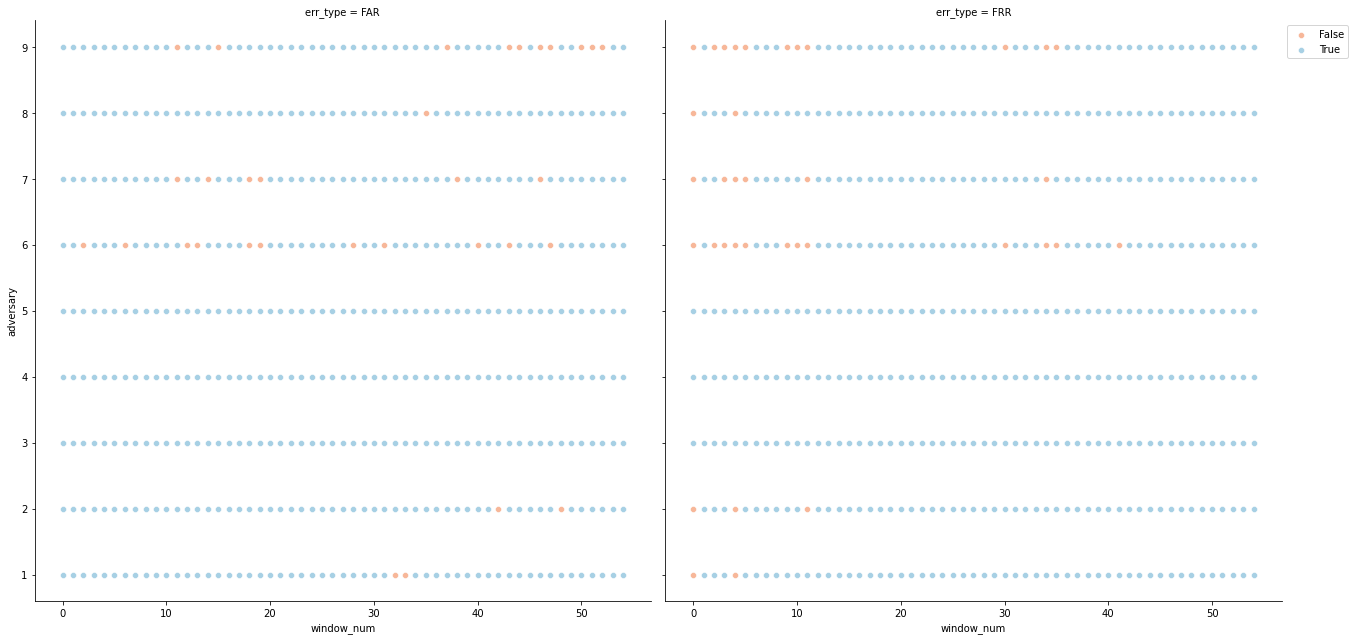

<Figure size 1080x576 with 0 Axes>

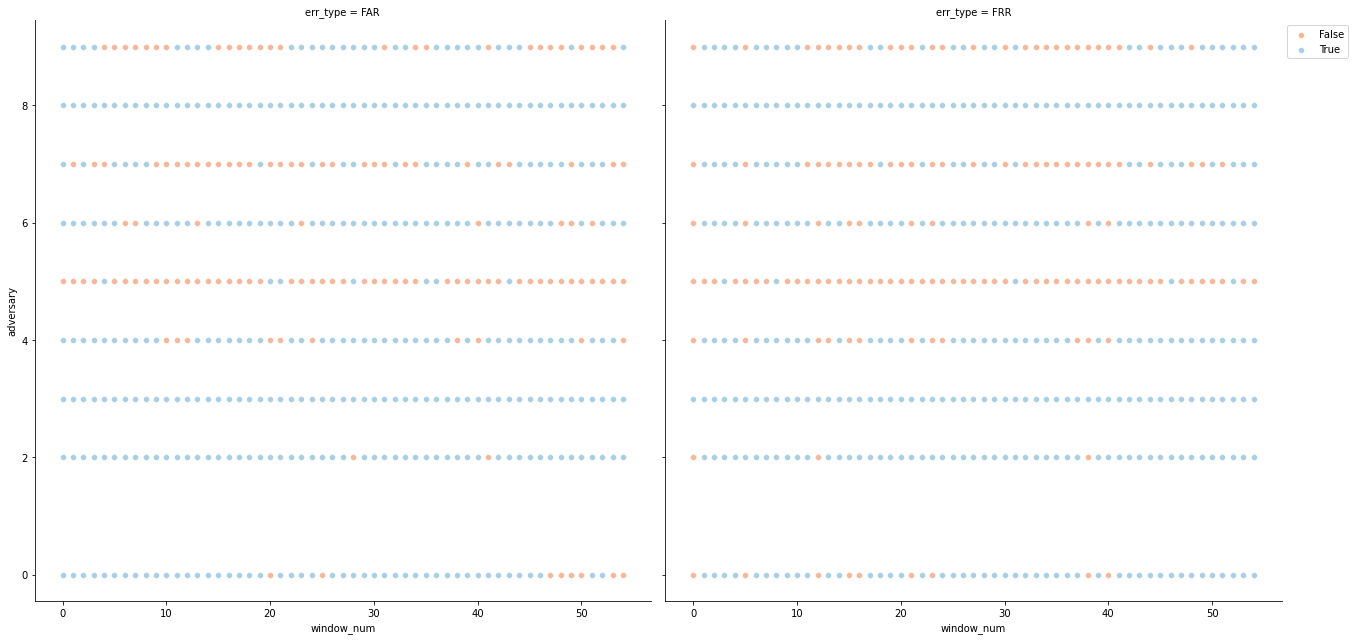

<Figure size 1080x576 with 0 Axes>

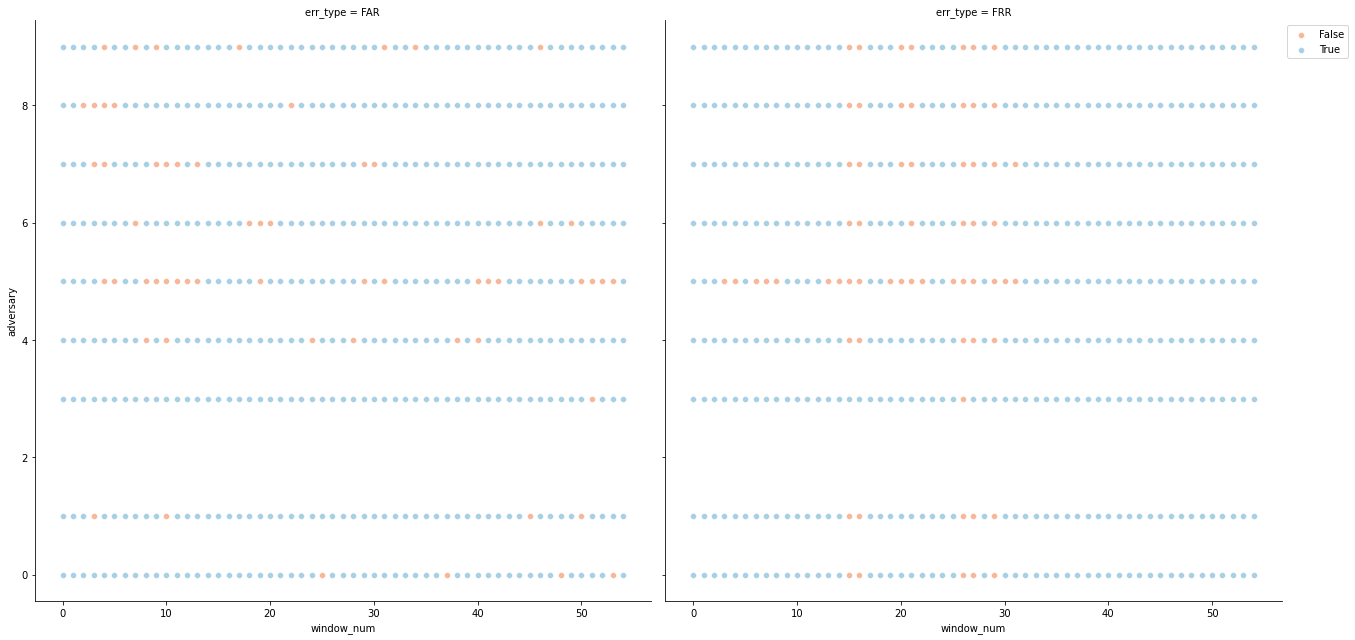

<Figure size 1080x576 with 0 Axes>

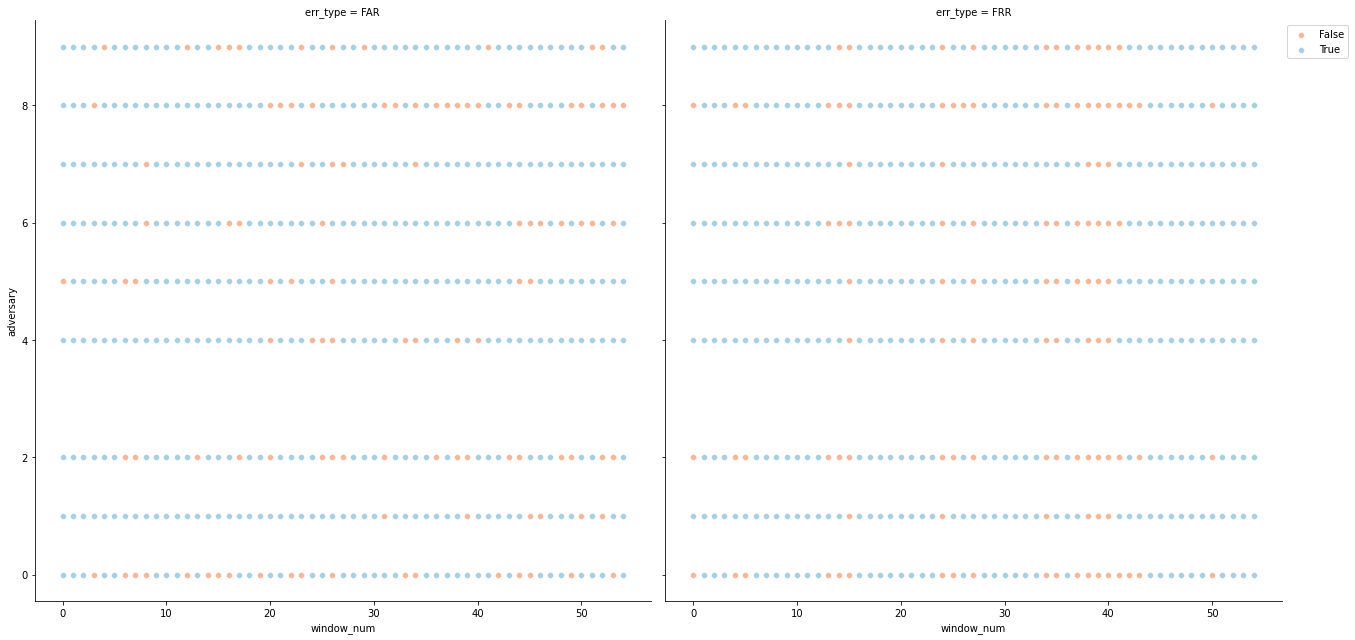

<Figure size 1080x576 with 0 Axes>

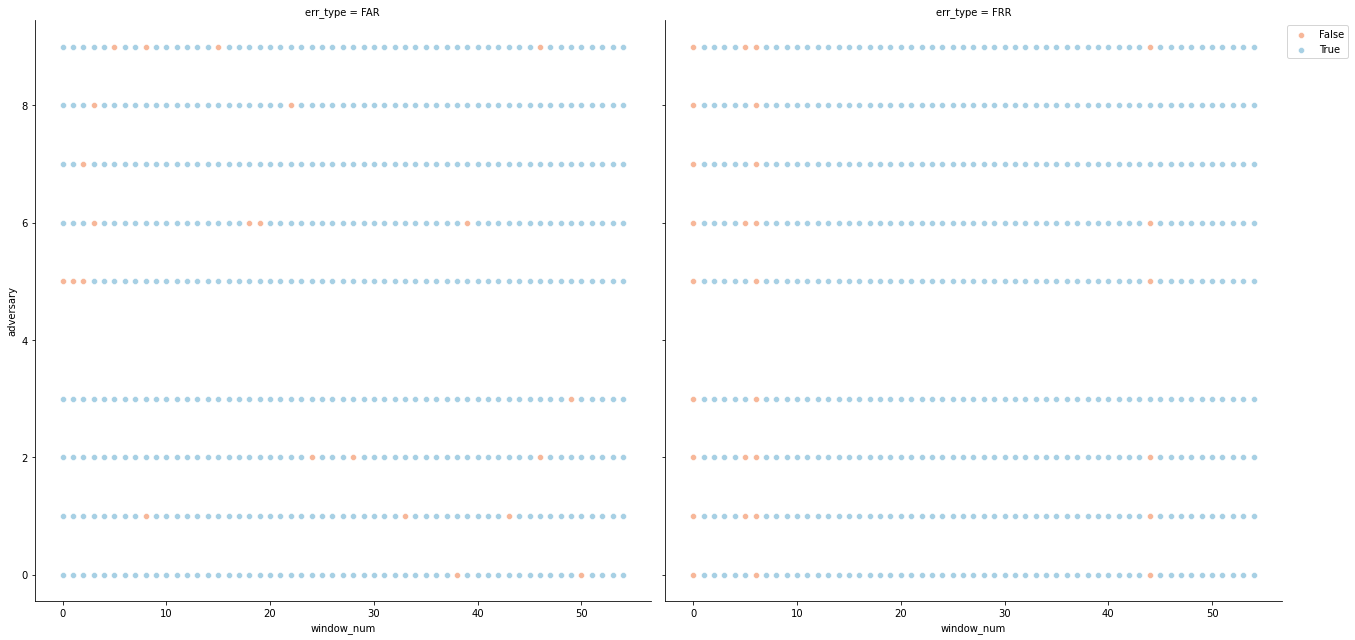

<Figure size 1080x576 with 0 Axes>

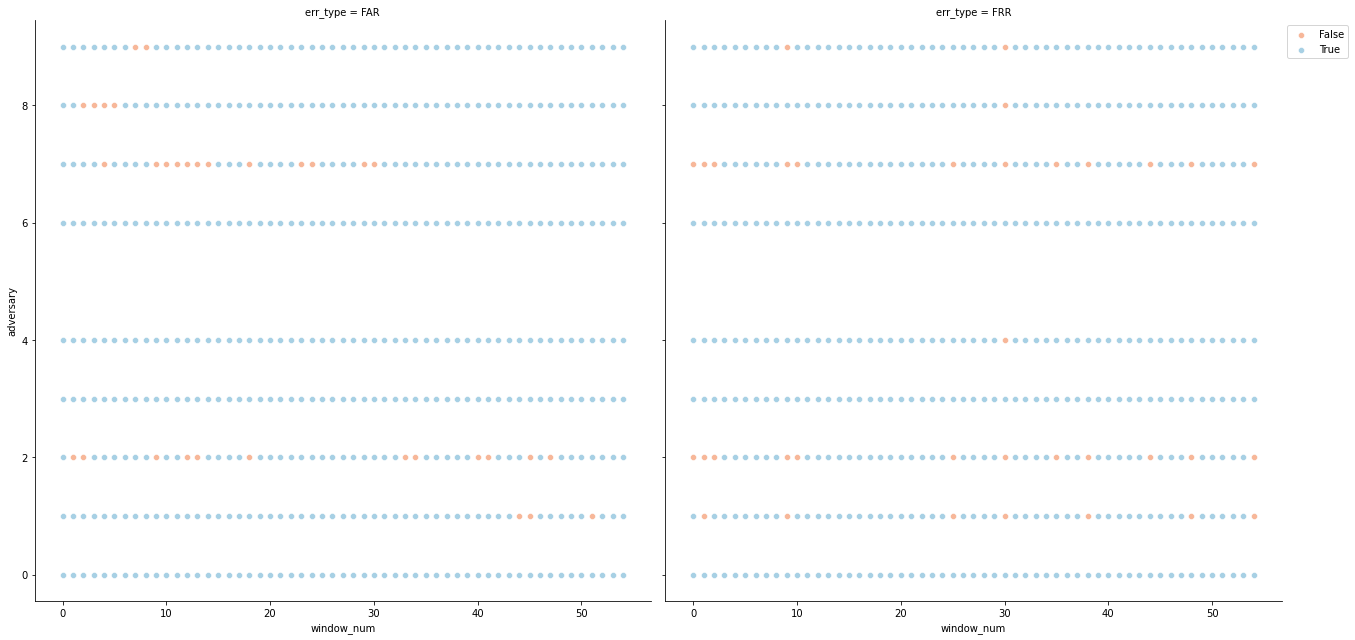

<Figure size 1080x576 with 0 Axes>

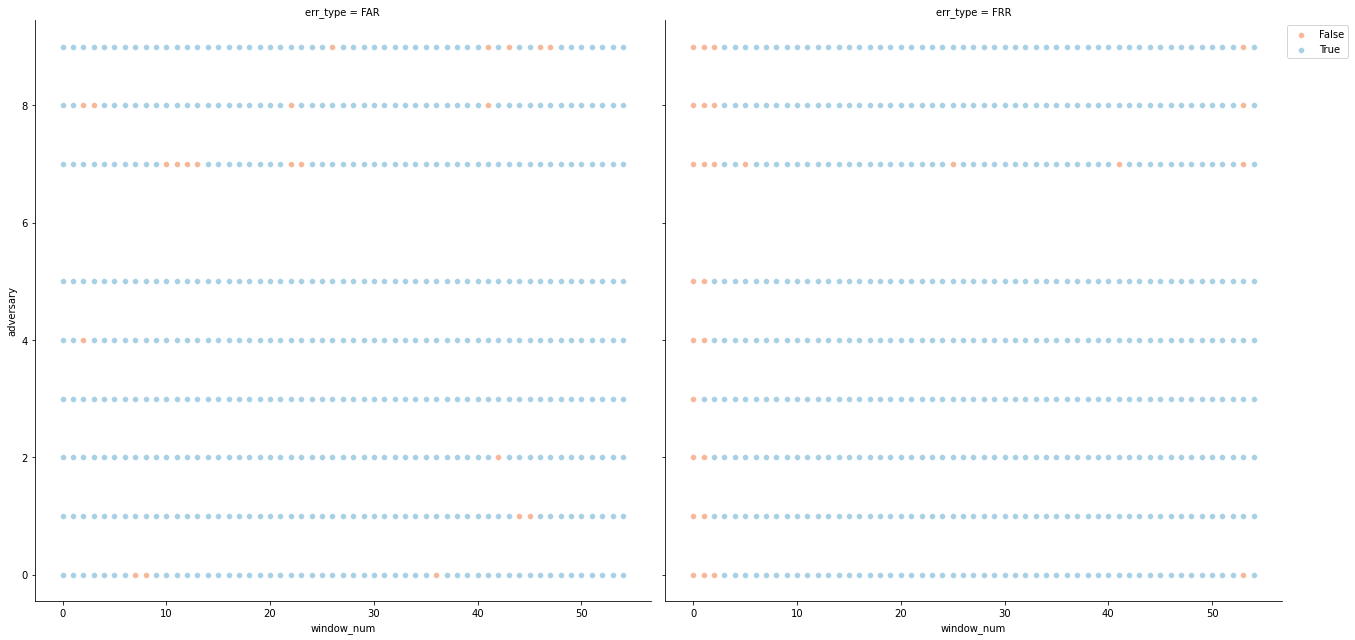

<Figure size 1080x576 with 0 Axes>

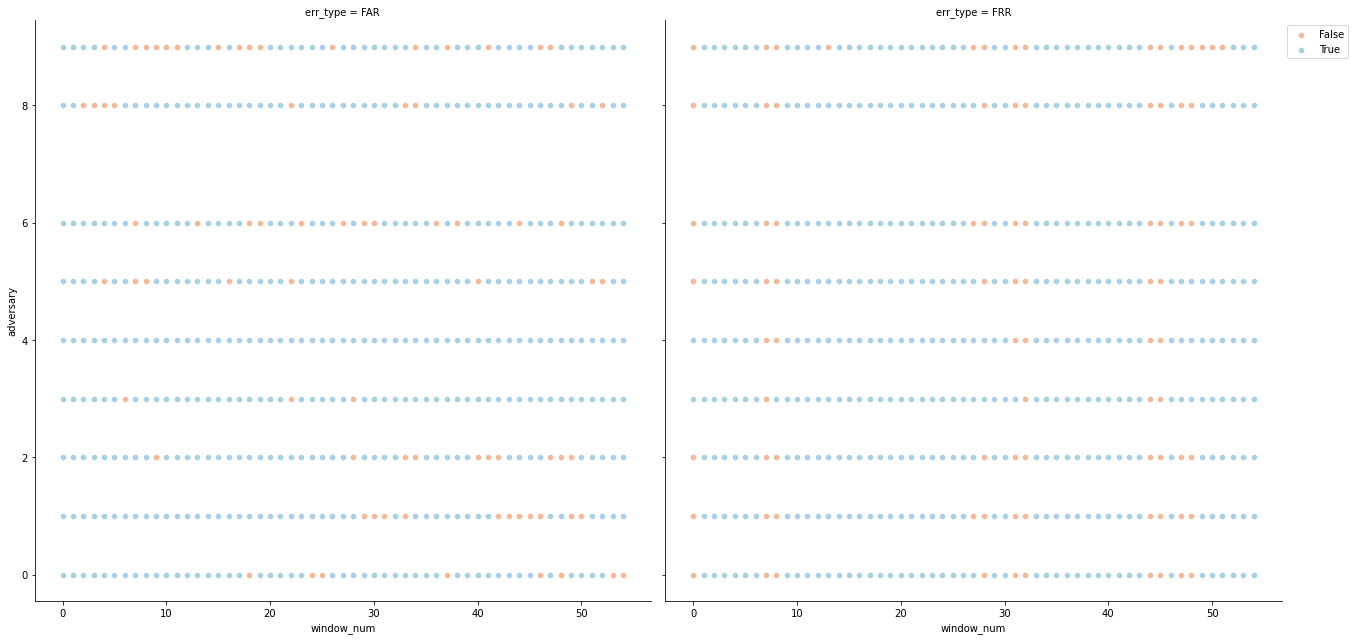

<Figure size 1080x576 with 0 Axes>

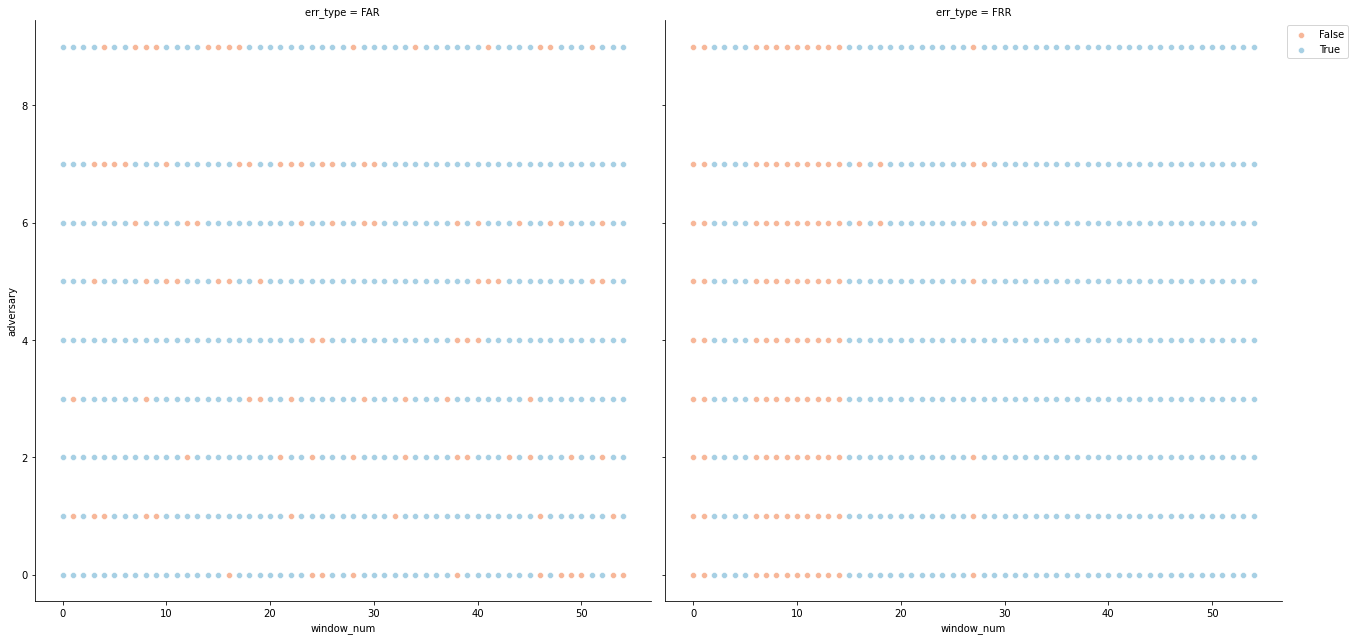

<Figure size 1080x576 with 0 Axes>

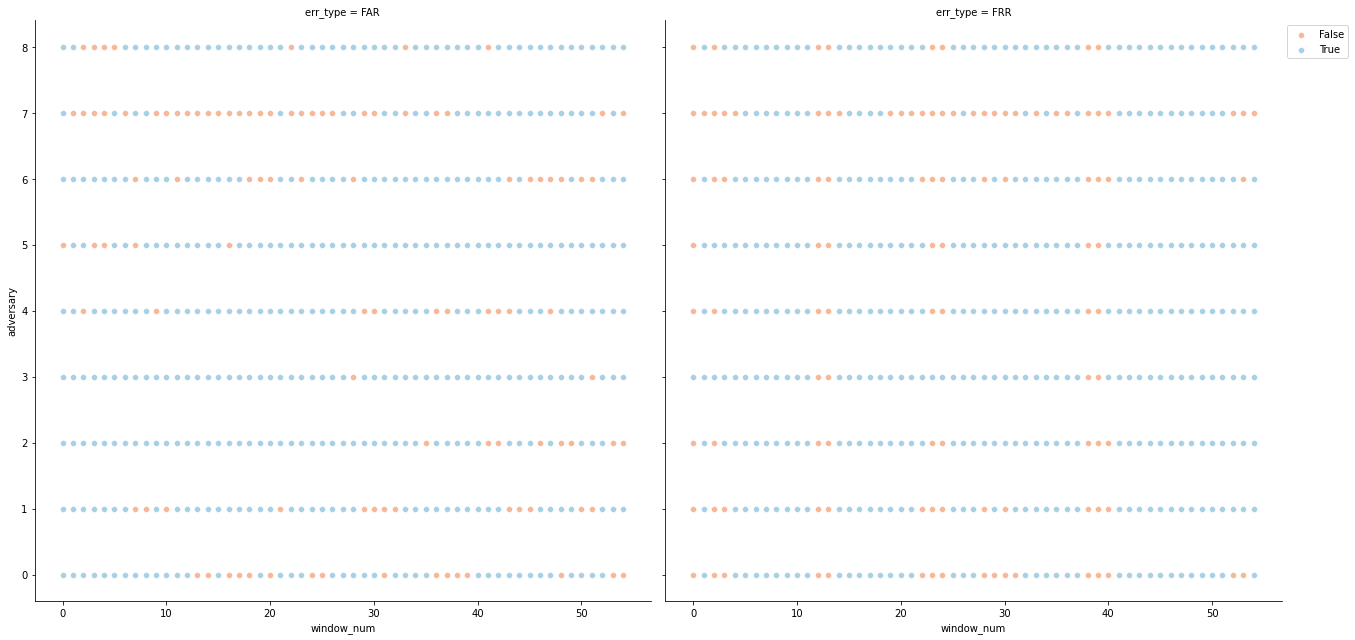

In [370]:
for owner in y_pred_tres_EER_dic:
    plot_far_frr_auth_window_result(owner)

In [277]:
import seaborn as sns; sns.set()

def plot_EER_vs_Windows_Size_graph_per_user():
    y_col = "EER"
    figsize=(30, 6)
    fontsize=11
    n_subject = len(EER_distro_df.columns)
    mean_col = EER_distro_df[y_col].mean()

    fig = plt.figure(figsize=figsize, dpi=180)
    ax = sns.boxplot(x="gen_user_id", y=y_col, data=EER_distro_df)#, **utils_boxplot_style)
    ax.set_ylim((0, 1))
    sns.swarmplot(x="gen_user_id", y=y_col, data=EER_distro_df, color=".25")

    plt.plot(
        [-0.6, figsize[0] + 0.6],
        [mean_col, mean_col],
        linestyle="dashed",
        linewidth=1,
        color=MAGENTA,
        alpha=0.7,
    )
    plt.text(n_subject + 0.6, mean_col, f"mean", fontsize=fontsize, color=MAGENTA)
    plt.text(
        n_subject + 0.6, mean_col - 0.04, f"{mean_col:.3f}", fontsize=fontsize, color=MAGENTA
    )
    plt.xticks(rotation=45)
    fig.tight_layout()
    plt.title(discription)
    
#     plt.savefig(f'{save_file_name}.png', bbox_inches='tight')
    
    fmri = sns.load_dataset("fmri")
    fmri_stats = fmri.groupby(['timepoint']).describe()

    x = fmri_stats.index
    medians = fmri_stats[('signal', '50%')]
    medians.name = 'signal'
    quartiles1 = fmri_stats[('signal', '25%')]
    quartiles3 = fmri_stats[('signal', '75%')]

    ax = sns.lineplot(x, medians) 
    ax.fill_between(x, quartiles1, quartiles3, alpha=0.3); 

In [279]:
EER_distro_df_dict[k]

,owner,adv_user_id,EER
0,0,1,0.192857
0,0,2,0.273810
0,0,3,0.178571
0,0,4,0.119048
0,0,5,0.154762
...,...,...,...
0,9,4,0.130952
0,9,5,0.325397
0,9,6,0.357143
0,9,7,0.577381


In [280]:
eer_vs_window_size_per_user_dict = {}
for owner in X_exp_train_dic.keys():
    eer_vs_window_size_per_user_dict[owner] = {}
    
for k in EER_distro_df_dict.keys():
    
    eer_vs_window_df = EER_distro_df_dict[k].groupby("owner").describe()
    for owner in X_exp_train_dic.keys():
        eer_vs_window_size_per_user_dict[owner][k.split()[1].strip(',')] = eer_vs_window_df.iloc[owner]

In [281]:
# fmri = sns.load_dataset("fmri")
# fmri_stats = fmri.groupby(['timepoint']).describe()

x = list(eer_vs_window_size_per_user_dict[owner].keys())
medians = fmri_stats[('signal', '50%')]
medians.name = 'signal'
quartiles1 = fmri_stats[('signal', '25%')]
quartiles3 = fmri_stats[('signal', '75%')]

ax = sns.lineplot(x, medians) 
ax.fill_between(x, quartiles1, quartiles3, alpha=0.3); 

NameError: name 'fmri_stats' is not defined

In [286]:
eer_vs_window_size_per_user_dict[0].keys()
eer_vs_window_size_per_user_dict[0]["125"]
mean_owner_dic = {}
for owner in eer_vs_window_size_per_user_dict:
    mean_owner_dic[owner] = {}
    mean_owner_dic[owner]["mean"] = {}
    for window_size in eer_vs_window_size_per_user_dict[owner]:
        mean_owner_dic[owner]["mean"][window_size] = (eer_vs_window_size_per_user_dict[owner][window_size].EER.loc['mean'])


# def extract_stats_eer_vs_window_size_per_user_dict(eer_vs_window_size_per_user_dict:
#     eer_vs_window_size_per_user_dict[0].keys()

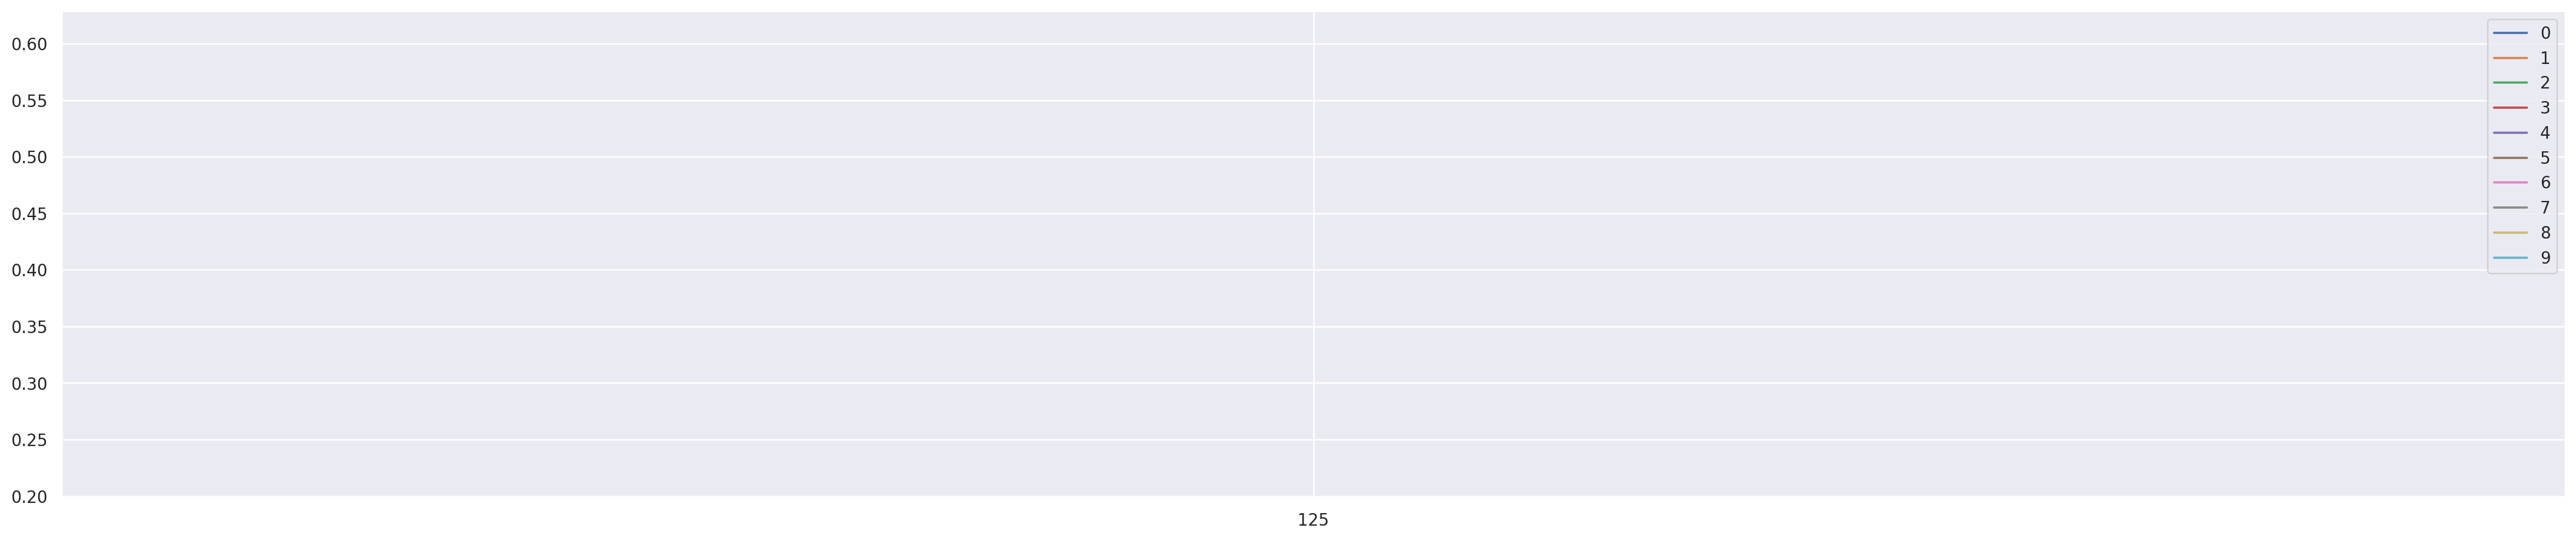

In [287]:
figsize=(30, 6)
fontsize=11
fig = plt.figure(figsize=figsize, dpi=180)
for owner in mean_owner_dic:
    ax = sns.lineplot(list(mean_owner_dic[owner]['mean'].keys()), list(mean_owner_dic[owner]['mean'].values()), label=owner, linestyle="-")


In [284]:
mean_owner_dic[0]['mean'].values()

dict_values([0.23987150415729216])

In [285]:
eer_vs_window_size_per_user_dict[0]

{'125': EER  count    9.000000
      mean     0.239872
      std      0.111323
      min      0.119048
      25%      0.178571
      50%      0.214286
      75%      0.261905
      max      0.501701
 Name: 0, dtype: float64}

In [214]:
# eer_vs_window_df=EER_distro_df_dict[k].groupby("gen_user_id").describe()
# eer_vs_window_df["x"] = k
# for k in list(EER_distro_df_dict.keys())[1:]:
#     new_row = EER_distro_df_dict[k].groupby("gen_user_id").describe()
#     new_row["x"] = k
#     eer_vs_window_df = pd.concat([eer_vs_window_df, new_row])


In [250]:
1

1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [163]:
temp_df_result = EER_distro_df_dict["window_size: 125, step_width: 250, scaler_clip: True"]
temp_df_result[temp_df_result.gen_user_id==0]["EER"].mean()

0.23987150415729216

In [154]:
EER_distro_df_dict["window_size: 125, step_width: 250, scaler_clip: True"].head(10)

,gen_user_id,adv_user_id,EER
0,0,1,0.192857
0,0,2,0.273810
0,0,3,0.178571
0,0,4,0.119048
0,0,5,0.154762
0,0,6,0.501701
0,0,7,0.214286
0,0,8,0.261905
0,0,9,0.261905
0,1,0,0.360119


In [142]:
EER_distro_df_dict.keys()

dict_keys(['window_size: 125, step_width: 250, scaler_clip: True', 'window_size: 250, step_width: 250, scaler_clip: True', 'window_size: 500, step_width: 250, scaler_clip: True', 'window_size: 750, step_width: 250, scaler_clip: True', 'window_size: 1000, step_width: 250, scaler_clip: True', 'window_size: 1250, step_width: 250, scaler_clip: True', 'window_size: 1500, step_width: 250, scaler_clip: True', 'window_size: 1750, step_width: 250, scaler_clip: True', 'window_size: 2000, step_width: 250, scaler_clip: True'])

In [114]:
print(Mean_EER_df["Mean_EER"])

0    0.311363
0    0.235292
0    0.167712
0    0.156379
0    0.163357
0    0.167944
0    0.169635
0    0.171837
0    0.185374
Name: Mean_EER, dtype: float64


In [134]:
for k in EER_distro_df_dict.keys():
    print(k)
#     plot_EER_distro(EER_distro_df_dict[k], k, save_file_name=f'WACA-NN1-{ "".join("-".join(k.split(", ")).split())}')

window_size: 125, step_width: 250, scaler_clip: True
window_size: 250, step_width: 250, scaler_clip: True
window_size: 500, step_width: 250, scaler_clip: True
window_size: 750, step_width: 250, scaler_clip: True
window_size: 1000, step_width: 250, scaler_clip: True
window_size: 1250, step_width: 250, scaler_clip: True
window_size: 1500, step_width: 250, scaler_clip: True
window_size: 1750, step_width: 250, scaler_clip: True
window_size: 2000, step_width: 250, scaler_clip: True


In [132]:
 "".join("-".join(k.split(", ")).split())

'window_size:2000-step_width:250-scaler_clip:True'

In [ ]:
y_col = "EER"
mean_col = EER_distro_df[y_col].mean()
mean_col

In [ ]:
print(len(X_exp2_train_dic[0]))

In [ ]:
# X_exp1_train_dic2[0]

In [ ]:
OCSVM_train_train_WACA_features_dic[0].shape

In [ ]:
get_new_scaler_dict["MinMaxScaler"]().clip

In [ ]:
# from sklearn.neighbors import NearestNeighbors
# # X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
# # nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
# gen_user_id = 0
# nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(OCSVM_train_train_WACA_features_dic[gen_user_id])
# # distances, indices = nbrs.kneighbors(X)
# distFRR, indices = nbrs.kneighbors(OCSVM_train_valid_WACA_features_dic[gen_user_id])
# distFRR = distFRR.mean(axis=1).reshape(distFRR.shape[0], 1)

# adv_user_id = 16
# distFAR, indices = nbrs.kneighbors(OCSVM_train_valid_WACA_features_dic[adv_user_id])
# distFAR = distFAR.mean(axis=1).reshape(distFAR.shape[0], 1)
# # distFAR

In [ ]:
# df_EER = pd.DataFrame()
# df_EER["dist_FAR"], df_EER['dist_FRR'] = distFAR.ravel(), distFRR.ravel()

In [ ]:
# r = getEER(distFRR, distFAR, thresholdList=np.arange(0, 1, 0.0001))
# print(r['EER'])
# r['EER_threshold']

In [ ]:
# df_EER.plot()

In [ ]:
# df_FRR.plot()

In [ ]:
# all_dist = np.concatenate([distFAR, distFRR])
# print(all_dist.shape)
# scaler = MinMaxScaler().fit(all_dist)

In [ ]:
# scaled_distFRR, scaled_distFAR = scaler.transform(distFRR), scaler.transform(distFAR)
# r = getEER(scaled_distFRR, scaled_distFAR, thresholdList=np.arange(0, 1, 0.00001))
# # r = getEER(scaled_distFRR, scaled_distFAR, thresholdList=[0.2])
# print(r['EER'])
# r['EER_threshold']

In [ ]:
# plt.plot(scaled_distFRR)
# plt.plot(np.where(scaled_distFAR<.01))

In [ ]:
# temp_eer, tres = utils_eer(
#         [-1, -1, -1, 1, 1, 1], [0, 0.9, 0.1, 0.74, 0.8, .9], return_threshold=True
#     )
# print(f"EER: {temp_eer:.3f}, Threshold: {tres:.3f} <-- Arbitrary case")

In [ ]:
# getEER([-0.74, -0.8, -.9], [0, -0.9, -0.1], thresholdList=np.arange(-1, 1, 0.0001))['EER']

In [ ]:
# y = [1]*distFRR.shape[0] + [-1]*distFAR.shape[0]
# y_pred = 1-np.concatenate([scaled_distFRR, scaled_distFAR]).ravel() 
# y_pred.shape

In [ ]:
# plt.plot(y_pred)

In [ ]:
# temp_eer, tres = utils_eer(
#         y, y_pred, return_threshold=True
#     )
# print(f"EER: {temp_eer:.9f}, Threshold: {tres:.9f} <-- Arbitrary case")

In [ ]:
# EER_distro_df["gen_user_id"].tail(50)

In [ ]:
OCSVM_train_valid_WACA_features_dic[16][0]

In [ ]:
OCSVM_train_valid_WACA_features_dic[16][0]

In [ ]:
OCSVM_train_train_WACA_features_dic[8][0]

In [ ]:
OCSVM_train_valid_WACA_features_dic[8][0]

In [ ]:
OCSVM_train_valid_WACA_features_dic2[8][0][0]

In [ ]:
OCSVM_train_train_WACA_features_dic2[8][0][0]

In [ ]:
OCSVM_train_valid_WACA_features_dic[0][0]

In [ ]:
OCSVM_train_valid_WACA_features_dic[28][0]

In [ ]:
nbrs.kneighbors(OCSVM_train_valid_WACA_features_dic[16])

In [ ]:
OCSVM_train_train_WACA_features_dic.keys()

In [ ]:
np.arange(9).reshape(1,9)

In [ ]:
# for k in OCSVM_train_valid_WACA_features_dic.keys():
#     distances, indices = nbrs.kneighbors(OCSVM_train_valid_WACA_features_dic[k])
#     plt.title(k)
#     fig = plt.plot(distances.mean(axis=1))

In [ ]:
OCSVM_train_valid_WACA_features_dic[0].shape

In [ ]:
# indices

In [ ]:
distances.shape

In [ ]:
utils_ppp(P)

In [ ]:
len(np.linspace(0.0001, 0.3))*len(np.logspace(-3, 3)) * 18

In [ ]:
param_dist = {
    "model__gamma": np.logspace(-3, 3), 
    "model__nu": np.linspace(0.0001, 0.3),
#     'scaler': [StandardScaler(), MinMaxScaler(),
#         Normalizer(), MaxAbsScaler()],
#     "selector__threshold": np.linspace(0, 2, num=1000),

}
import warnings
warnings.filterwarnings("ignore")


df_results = None  # Will be filled with randomsearch scores


# Don't need to loop over to find the best PCA.
for run in tqdm(range(3)):
#     df_results[run] = {}
    
    for owner_idx in tqdm(
        range(len(train_set)),
        desc="Owner",
    ):
        run_seed = SEED + run
        train_dic, valid_test_dic = OCSVM_train_train_WACA_features_dic, OCSVM_train_valid_WACA_features_dic
        X_vals_owner_idx = utils_create_cv_splits(owner_idx, train_dic, valid_test_dic, seed=run_seed)

        X_test_regular = X_vals_owner_idx['X_test_regular'].copy()
        X_test_anomalous = X_vals_owner_idx['X_test_anomalous'].copy()
        
#         print(X_vals_owner_idx['cv_splits'])
        cv_splits = X_vals_owner_idx['cv_splits']
        
#         pca = PCA(n_components = run)
#         X_train = pca.fit_transform(X_train)
#         X_test_regular = pca.transform(X_test_regular)
#         X_test_anomalous = pca.transform(X_test_anomalous)
        
#         pca_fs.add_user_pca(owner_idx, pca)
        
        clf = svm.OneClassSVM(kernel=P.ocsvm_kernel)
        
        pipeline = Pipeline([
#                             ('scaler', StandardScaler()), 
                            ('scaler', get_new_scaler_dict[P.scaler]()), 
#                             ('scaler', Normalizer()),
#                              ('pca', pca), 
#                              ('selector', VarianceThreshold()), 
                             ('model', clf)
                            ])
        
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_dist,
            cv=cv_splits,
#             n_iter=120,
            n_iter=80,
#             n_iter=480,
            n_jobs=CORES,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=1,
            return_train_score=False,
            iid=False,
            error_score="raise",
            random_state=run_seed
        )
#         search = GridSearchCV(
#             pipeline,
#             param_grid=param_dist,
#             cv=cv_splits,
#             n_jobs=CORES,
#             refit=False,
#             scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
#             verbose=1,
#             return_train_score=False,
#             iid=False,
#             error_score="raise",
#         )
#         print(X_train.shape)
#         print(X_test_anomalous.shape)

        
        search.fit(X_vals_owner_idx['X_train'], X_vals_owner_idx['y_train'])
        impostors = [idx for idx in range(len(train_set)) if idx != owner_idx]

        df_report = utils_cv_report(search, owner_idx, impostors)
        df_report["run"] = run
        df_results = pd.concat([df_results, df_report], sort=False)
        


df_results

In [ ]:
380*3

In [ ]:
pd.set_option('display.max_columns', None)
df_results[df_results['run']==1 ].groupby('owner').head(40)[6*20:8*20]

In [ ]:
len(df_results[(df_results.rank_test_eer == 1) & (df_results.rank_test_accuracy == 1)])

In [ ]:
pd.set_option('display.max_rows', None)
df_results[(df_results.rank_test_eer == 1) & (df_results.rank_test_accuracy == 1)].groupby('owner').head(40)[:269]

In [ ]:
1*19*3

In [ ]:
df_results[df_results["owner"] == 14].shape

In [ ]:
# df_results[df_results["owner"] == 14][ df_results["rank_test_eer"] == 1]

In [ ]:
display(
    df_results[df_results["rank_test_eer"] == 1]
    .sort_values("mean_test_eer")
    .head(30)
)

In [ ]:
display(
    df_results[df_results["rank_test_eer"] == 1][
        [
            "mean_fit_time",
            "param_model__nu",
            "param_model__gamma",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

In [ ]:
fig = utils_plot_randomsearch_results(df_results, n_top=1)


In [ ]:
P.ocsvm_nu, P.ocsvm_gamma = 0.098, 0.002
# NORMALIZER-SCALER
# P.ocsvm_nu, P.ocsvm_gamma = 0.074, 0.029
# ROBUST-SCALER-250
# P.ocsvm_nu, P.ocsvm_gamma = 0.037, 0.001
# ROBUST-SCALER-1000-1000
# P.ocsvm_nu, P.ocsvm_gamma = 0.141, 0.494
# ROBUST-SCALER-1000-250
# P.ocsvm_nu, P.ocsvm_gamma = 0.147, 0.655
# P.ocsvm_nu, P.ocsvm_gamma = 0.098, 0.003

In [ ]:
utils_ppp(P)

In [ ]:
# utils_plot_acc_eer_dist(df_plot, "Test Accuracy")

In [ ]:
# utils_plot_acc_eer_dist(df_results, "Test EER")

In [ ]:
from sklearn.model_selection import KFold 
temp_split = KFold(n_splits=5, shuffle=False, random_state=None)
temp_split.get_n_splits(X_exp2_test_dic[0])

In [ ]:
for train_index, test_index in temp_split.split(X_exp2_test_dic[0]):
    print(train_index, test_index)
    print('---')

In [ ]:
X_vals_owner_idx['X_train'][162: 243].sum()

In [ ]:
X_vals_owner_idx['X_train'][243: 324].sum()

In [ ]:
train_test_cv_splits[1]

In [ ]:
test_df_results = None  # Will be filled with randomsearch scores
for run in tqdm(range(5)):


    for owner_idx in tqdm(
        range(len(test_set)),
        desc="Owner",
    ):

        
        run_seed = SEED + run
        train_dic, valid_test_dic = OCSVM_test_train_WACA_features_dic, OCSVM_test_test_WACA_features_dic
        X_vals_owner_idx = utils_create_cv_splits(owner_idx, train_dic, valid_test_dic, seed=run_seed)
        
        X_test_regular = X_vals_owner_idx['X_test_regular']
        X_test_anomalous = X_vals_owner_idx['X_test_anomalous']

        train_test_cv_splits = X_vals_owner_idx['cv_splits']
        
        
        pca = PCA(n_components = run+3)
#         X_train = pca.fit_transform(X_train)
#         X_test_regular = pca.transform(X_test_regular)
#         X_test_anomalous = pca.transform(X_test_anomalous)
        
        clf = svm.OneClassSVM(kernel=P.ocsvm_kernel, nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)
        pipeline = Pipeline([
                            ('scaler', get_new_scaler_dict[P.scaler]()), 
#                             ('scaler2', Normalizer()),#best result
#                              ('pca', pca), 
#                              ('selector', VarianceThreshold()), 
                            ('model', clf)
                            ])
        
        scores = cross_validate(
            pipeline,
            X_vals_owner_idx['X_train'],
            X_vals_owner_idx['y_train'],
            cv=train_test_cv_splits,
            scoring={
                "eer": utils_eer_scorer,
                "accuracy": "accuracy",
                "precision": "precision",
                "recall": "recall",
            },
            n_jobs=CORES,
            verbose=1,
            return_train_score=True,
        )
#         print(df_score["test_eer"])
        df_score = pd.DataFrame(scores)
        df_score["owner"] = test_set[owner_idx]
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        test_df_results = pd.concat([test_df_results, df_score], axis=0)
        

test_df_results.head()

In [ ]:
test_df_plot = test_df_results.rename(
    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
).astype({"Owner": str})

In [ ]:
# test_df_plot[test_df_plot["Owner"]=="9"]

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")


In [ ]:
data = []
total = None
for k in tqdm(test_pca_results):
    total = list(test_pca_results[k]["total"].values())
    data.append([k] + total)
    
# Create the pandas DataFrame
columns = ["pca_n_components"] + list(test_pca_results[k]["total"].keys())
df = pd.DataFrame(data, columns = columns)
df

In [ ]:
fig, ax =plt.subplots(1,1, figsize=(8,8))

ax.set_title('different pca_n_component values on test_set')
g = sns.lineplot(x=df.pca_n_components, y=df.FAR, label = 'FAR', ax = ax)
g = sns.lineplot(x=df.pca_n_components, y=df.FRR, label = 'FRR', ax = ax)
g = sns.lineplot(x=df.pca_n_components, y=df.train_err_rate, label = 'train_err_rate', ax = ax)




# g.set_xticks(y_ticks)
ax.set_xlabel('n_components')


fig.show()

In [ ]:
# df_results[0]

In [ ]:
data = []
total = None
for k in tqdm(train_pca_results):
    total = list(train_pca_results[k]["total"].values())
    data.append([k] + total)
    
# Create the pandas DataFrame
columns = ["pca_n_components"] + list(train_pca_results[k]["total"].keys())
df = pd.DataFrame(data, columns = columns)
df

In [ ]:
fig, ax =plt.subplots(1,1, figsize=(8,8))

ax.set_title('different pca_n_component values on train_set')
g = sns.lineplot(x=df.pca_n_components, y=df.FAR, label = 'FAR', ax = ax)
g = sns.lineplot(x=df.pca_n_components, y=df.FRR, label = 'FRR', ax = ax)
g = sns.lineplot(x=df.pca_n_components, y=df.train_err_rate, label = 'train_err_rate', ax = ax)




# g.set_xticks(y_ticks)
ax.set_xlabel('n_components')


fig.show()